In [3]:
import sys
sys.path.append('/kaggle/input/d2l-module')

In [16]:
import collections
import math
import os
import shutil
import pandas as pd
import torch
import torchvision
from torch import nn
from datetime import datetime
from d2l import torch as d2l

d2l.DATA_HUB['cifar10_tiny']=(d2l.DATA_URL+'kaggle_cifar10_tiny.zip','2068874e4b9a9f0fb07ebe0ad2b29754449ccacd')
demo=False   # 如果使用完整的Kaggle竞赛的数据集,设置demo为False
if demo:
    data_dir=d2l.download_extract('cifar10_tiny')
else:
#     data_dir='../data/cifar-10/'
    data_dir='/kaggle/input/cifar-10-object-recognition-in-images-organized/'

In [5]:
def read_csv_labels(fname): #@save
    """读取fname来给标签字典返回一个文件名"""
    with open(fname,'r') as f:
        # 跳过文件头行(列名)
        lines=f.readlines()[1:]
    tokens=[l.rstrip().split(',') for l in lines]
    return dict(((name,label) for name,label in tokens))

labels=read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
print('# 训练样本:',len(labels))
print('# 类别:',len(set(labels.values())))

# 训练样本: 50000
# 类别: 10


In [6]:
def copyfile(filename,target_dir):  #@save
    """将文件复制到目标目录"""
    os.makedirs(target_dir,exist_ok=True)
    shutil.copy(filename,target_dir)

def reorg_train_valid(data_dir,labels,valid_ratio): #@save
    """将验证集从原始的训练集中拆分出来"""
    n=collections.Counter(labels.values()).most_common()[-1][1] # 训练数据集中样本最少的类别中的样本数
    n_valid_per_label=max(1,math.floor(n*valid_ratio))  # 验证集中每个类别的样本数
    label_count={}
    for train_file in os.listdir(os.path.join(data_dir,'train')):
        label=labels[train_file.split('.')[0]]
        fname=os.path.join(data_dir,'train',train_file)
        copyfile(fname,os.path.join(data_dir,'train_valid_test','train_valid',label))
        if label not in label_count or label_count[label]<n_valid_per_label:
            copyfile(fname,os.path.join(data_dir,'train_valid_test','valid',label))
            label_count[label]=label_count.get(label,0)+1
        else:
            copyfile(fname,os.path.join(data_dir,'train_valid_test','train',label))
    return n_valid_per_label

def reorg_test(data_dir): #@save
    """在预测期间整理测试集,以方便读取"""
    for test_file in os.listdir(os.path.join(data_dir,'test')):
        copyfile(os.path.join(data_dir,'test',test_file),os.path.join(data_dir,'train_valid_test','test','unknown'))

def reorg_cifar10_data(data_dir,valid_ratio):
    labels=read_csv_labels(os.path.join(data_dir,'trainLabels.csv'))
    reorg_train_valid(data_dir,labels,valid_ratio)
    reorg_test(data_dir)

batch_size=32 if demo else 128
valid_ratio=0.1
# reorg_cifar10_data(data_dir,valid_ratio)

In [7]:
transform_train=torchvision.transforms.Compose([
    torchvision.transforms.Resize(40),
    torchvision.transforms.RandomResizedCrop(32,scale=(0.64,1.0),ratio=(1.0,1.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],[0.2023,0.1994,0.2010])
])
transform_test=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.4914,0.4822,0.4465],[0.2023,0.1994,0.2010])
])

train_ds,train_valid_ds=[torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_train) for folder in ['train','train_valid']]
valid_ds,test_ds=[torchvision.datasets.ImageFolder(os.path.join(data_dir,'train_valid_test',folder),transform=transform_test) for folder in ['valid','test']]

train_iter,train_valid_iter=[torch.utils.data.DataLoader(dataset,batch_size,shuffle=True,drop_last=True) for dataset in (train_ds,train_valid_ds)]
valid_iter=torch.utils.data.DataLoader(valid_ds,batch_size,shuffle=False,drop_last=True)
test_iter=torch.utils.data.DataLoader(test_ds,batch_size,shuffle=False,drop_last=False)

In [8]:
def get_net():
    num_classes=10
    net=d2l.resnet18(num_classes,3)
    return net

loss=nn.CrossEntropyLoss(reduction='none')

def train(net,train_iter,valid_iter,num_epochs,lr,wd,devices):
    trainer=torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay=wd)
    scheduler=torch.optim.lr_scheduler.MultiStepLR(trainer,[140,190],0.1)
    num_batches,timer=len(train_iter),d2l.Timer()
    legend=['train loss','train acc']
    if valid_iter is not None:
        legend.append('valid acc')
    animator=d2l.Animator(xlabel='epoch',xlim=[1,num_epochs],ylim=[0,1],legend=legend)
    net=nn.DataParallel(net,device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        net.train()
        metric=d2l.Accumulator(3)
        for i,(features,labels) in enumerate(train_iter):
            timer.start()
            l,acc=d2l.train_batch_ch13(net,features,labels,loss,trainer,devices)
            metric.add(l,acc,labels.shape[0])
            timer.stop()
        animator.add(epoch+1,(metric[0]/metric[2],metric[1]/metric[2],None))
        if valid_iter is not None:
            valid_acc=d2l.evaluate_accuracy_gpu(net,valid_iter)
            animator.add(epoch+1,(None,None,valid_acc))
        scheduler.step()
    measures=(f'train loss {metric[0]/metric[2]:.3f}, train acc {metric[1]/metric[2]:.3f}')
    if valid_iter is not None:
        measures+=f', valid acc {valid_acc:.3f}'
    print(measures+f'\n{metric[2]*num_epochs/timer.sum():.1f} examples/sec on {str(devices)}')

train loss 0.002, train acc 0.999, valid acc 0.902
1321.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


AttributeError: module 'datetime' has no attribute 'now'

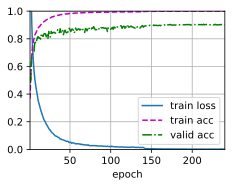

In [11]:
devices,num_epochs,lr,wd=d2l.try_all_gpus(),240,5e-4,5e-4
net=get_net()
train(net,train_iter,valid_iter,num_epochs,lr,wd,devices)
torch.save(net.state_dict(),os.path.join(data_dir,'resnet18-cifar10-'+str(num_epochs)+'epochs-'+datetime.now().strftime("%Y%m%d%H%M%S")+'.pth'))

In [19]:
torch.save(net.state_dict(),'resnet18-cifar10-'+str(num_epochs)+'epochs-'+datetime.now().isoformat()+'.pth')

In [15]:
# 太贵了，不在整个训练集上训练了
#net=get_net()
#train(net,train_valid_iter,None,num_epochs,lr,wd,devices,lr_period,lr_decay)
#torch.save(net.state_dict(),os.path.join(data_dir,'resnet18-cifar10-'+str(num_epochs)+'epochs-'+datetime.now().strftime("%Y%m%d%H%M%S")+'.pth'))
net.eval()
preds=[]
for X,_ in test_iter:
    y_hat=net(X.to(devices[0]))
    preds.extend(y_hat.argmax(dim=1).type(torch.int32).cpu().numpy())
sorted_ids=list(range(1,len(test_ds)+1))
sorted_ids.sort(key=lambda x:str(x))
df=pd.DataFrame({'id':sorted_ids,'label':preds})
df['label']=df['label'].apply(lambda x:train_valid_ds.classes[x])
# df.to_csv(os.path.join(data_dir,'submission.csv'),index=False)
df.to_csv('submission.csv',index=False)